In [5]:
!pip install google_play_scraper
!pip install textblob
from google_play_scraper import app
import pandas as pd
import numpy as np
import sklearn
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import textblob
#from wordcloud import WordCloud
from pathlib import Path
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score

import pickle
import re
import time
import datetime                              # access to %%time, for timing individual notebook cells
import os
from PIL import Image
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (15,10)

In [7]:
#Android App NHS link from Google Play at
#https://play.google.com/store/apps/details?id=uk.nhs.covid19.production&hl=en_GB&gl=US
#The apps ID found in the link after id=uk.nhs.covid19.production
#The apps name on Google Play titled: NHS COVID-19 Department of Health and Social Care, UK Government
#Dated 17 April 2022: number of reviews 134,397

from google_play_scraper import app, Sort, reviews_all

nhs_reviews = reviews_all(
    'uk.nhs.covid19.production',
    sleep_milliseconds=0, # defaults to 0
    lang='en', # defaults to 'en'
    sort=Sort.NEWEST, # defaults to Sort.MOST_RELEVANT
)

In [8]:
#Save the NHS Apps reviews into dataframe
df_nhsrev = pd.DataFrame(np.array(nhs_reviews),columns=['content'])
df_nhsrev = df_nhsrev.join(pd.DataFrame(df_nhsrev.pop('content').tolist()))
df_nhsrev.to_csv(r'C:\Users\Hafidz\PhDwork\APPREV\df_nhsrev.csv', index=False)
df_nhsrev.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,gp:AOqpTOG01deR4gBbtDBiTicCQLmylUN9PvDl2EL9MB2...,Morgwn,https://play-lh.googleusercontent.com/a-/AOh14...,Pointless... absolutely pointless is what this...,1,0,4.28.1 (306),2022-05-18 10:10:25,None,NaT
1,gp:AOqpTOH3D6omXNaI_ndFh5-hoOU193A-IcibLYYOMEG...,Alan Neville,https://play-lh.googleusercontent.com/a-/AOh14...,Easy to use once set up,5,0,4.28.1 (306),2022-05-18 07:17:32,None,NaT
2,gp:AOqpTOGrBWnNTJ1vIvj1zry8Ytm8i6Vgv6bl-XCywfq...,Darryl Duku,https://play-lh.googleusercontent.com/a/AATXAJ...,From health care and COVID-19,5,0,4.28.1 (306),2022-05-17 20:37:23,None,NaT
3,gp:AOqpTOERL26e8HCkBEtnSC1EhIbKZsTqxHSfCT1rEb5...,Lynne Ryan,https://play-lh.googleusercontent.com/a-/AOh14...,Had half a notification this morning then it d...,1,0,4.28.1 (306),2022-05-17 17:50:24,None,NaT
4,gp:AOqpTOHeqTATzy_kUcGrbs_pT0sC05OdNdywfRD2oZs...,Susan Mcmillan,https://play-lh.googleusercontent.com/a/AATXAJ...,Easy to use and fast response,5,0,4.28 (303),2022-05-17 13:34:22,None,NaT


In [9]:
#Information on the table 
df_nhsrev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22443 entries, 0 to 22442
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              22443 non-null  object        
 1   userName              22443 non-null  object        
 2   userImage             22443 non-null  object        
 3   content               22443 non-null  object        
 4   score                 22443 non-null  int64         
 5   thumbsUpCount         22443 non-null  int64         
 6   reviewCreatedVersion  19243 non-null  object        
 7   at                    22443 non-null  datetime64[ns]
 8   replyContent          14044 non-null  object        
 9   repliedAt             14044 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(6)
memory usage: 1.7+ MB


In [10]:
print(df_nhsrev.reviewCreatedVersion.unique())
print(df_nhsrev.reviewCreatedVersion.nunique())

['4.28.1 (306)' '4.28 (303)' None '4.26.1 (280)' '3.6.1 (70)' '4.27 (297)'
 '4.22 (258)' '4.26.2 (286)' '3.7.2 (85)' '4.13.1 (213)' '4.16 (230)'
 '4.14.1 (225)' '4.22.3 (266)' '4.25 (272)' '4.26 (276)' '4.1.1 (124)'
 '4.17 (240)' '4.22.4 (269)' '4.7 (168)' '4.19 (246)' '3.6.2 (73)'
 '3.10 (100)' '4.14 (218)' '4.10 (189)' '4.4 (146)' '4.22.2 (265)'
 '3.6 (69)' '4.22.1 (262)' '4.9 (185)' '3.12.2 (114)' '4.6 (159)'
 '3.9 (96)' '4.19.1 (253)' '4.0.1 (118)' '4.18 (244)' '3.6 (68)'
 '3.7 (81)' '4.1 (123)' '4.12 (201)' '4.5 (152)' '4.2 (131)' '4.3 (136)'
 '3.1.0 (41)' '4.13 (208)' '3.12 (111)' '3.7.1 (83)' '4.8 (178)'
 '4.7.1 (169)' '4.0 (117)' '3.0.0 (35)']
49


In [11]:
#We do not need data for column reviewId, userName, userImage so
#we will show only these column
df_nhsrev.loc[:,["content","score","thumbsUpCount", "reviewCreatedVersion", "at", "replyContent", "repliedAt"]]

,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,Pointless... absolutely pointless is what this...,1,0,4.28.1 (306),2022-05-18 10:10:25,None,NaT
1,Easy to use once set up,5,0,4.28.1 (306),2022-05-18 07:17:32,None,NaT
2,From health care and COVID-19,5,0,4.28.1 (306),2022-05-17 20:37:23,None,NaT
3,Had half a notification this morning then it d...,1,0,4.28.1 (306),2022-05-17 17:50:24,None,NaT
4,Easy to use and fast response,5,0,4.28 (303),2022-05-17 13:34:22,None,NaT
...,...,...,...,...,...,...,...
22438,Tells me is installed but not on phone. Can't ...,3,7,3.0.0 (35),2020-08-13 16:25:10,"Hello, the app is located next to other apps y...",2020-08-13 16:13:18
22439,The emails from the NHS could do a better job ...,4,19,3.0.0 (35),2020-08-13 16:04:40,"Hello, thank you for your comments, we really ...",2020-08-14 07:37:04
22440,Seems to work really well. Super simple setup....,5,9,3.0.0 (35),2020-08-13 16:03:33,"Hello, thank you for your comments, we really ...",2020-08-14 07:37:19
22441,"Not able to install ,code didn't work",1,0,3.0.0 (35),2020-08-13 15:27:46,"Hello, the unique codes are single-use. If you...",2020-08-13 15:39:11


In [12]:
!pip install emoji

import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 200)
#from pandas_profiling import ProfileReport
import regex
import nltk
import wordcloud
import textblob

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

import string
import re
import emoji

In [15]:
#Creating polarity on the column: content (review from the apps) using TextBlob
#Read https://textblob.readthedocs.io/en/dev/quickstart.html

from textblob import TextBlob
df_nhsrev['sentiment_polarity'] = df_nhsrev['content'].apply(lambda x: TextBlob(x).polarity)
df_nhsrev['sentiment_subjective'] = df_nhsrev['content'].apply(lambda x: TextBlob(x).subjectivity)

In [16]:
#df_nhsrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","at"]]
df_nhsrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective"]]

,content,score,sentiment_polarity,sentiment_subjective
0,"Pointless... absolutely pointless is what this app has unfortunately become. It doesn't trace people you're physically near to anymore or anything of the sort, so you'd be none the wiser if you we...",1,-0.060000,0.680000
1,Easy to use once set up,5,0.433333,0.833333
2,From health care and COVID-19,5,0.000000,0.000000
3,Had half a notification this morning then it disappeared spent all day trying to find it. No idea what I'm supposed to do now apart from worrying,1,-0.133333,0.133333
4,Easy to use and fast response,5,0.316667,0.716667
...,...,...,...,...
22438,Tells me is installed but not on phone. Can't get as far as putting the code I have been given in. Doesn't inspire confidence. It eventually downloaded and the code works. This needs to be slicker...,3,0.100000,1.000000
22439,"The emails from the NHS could do a better job of highlighting the access codes, since they do waffle on quite a bit and we're all busy. Assuming you did read your email carefully and collected the...",4,0.346667,0.591667
22440,Seems to work really well. Super simple setup. People stop giving it 1* because you don't have a signup code. That is not what the rating system is for.,5,0.177778,0.407937
22441,"Not able to install ,code didn't work",1,-0.250000,0.625000


In [17]:
#Check number of reviews scores
df_nhsrev['score'].value_counts()

1    9171
5    7000
3    2216
2    2128
4    1928
Name: score, dtype: int64

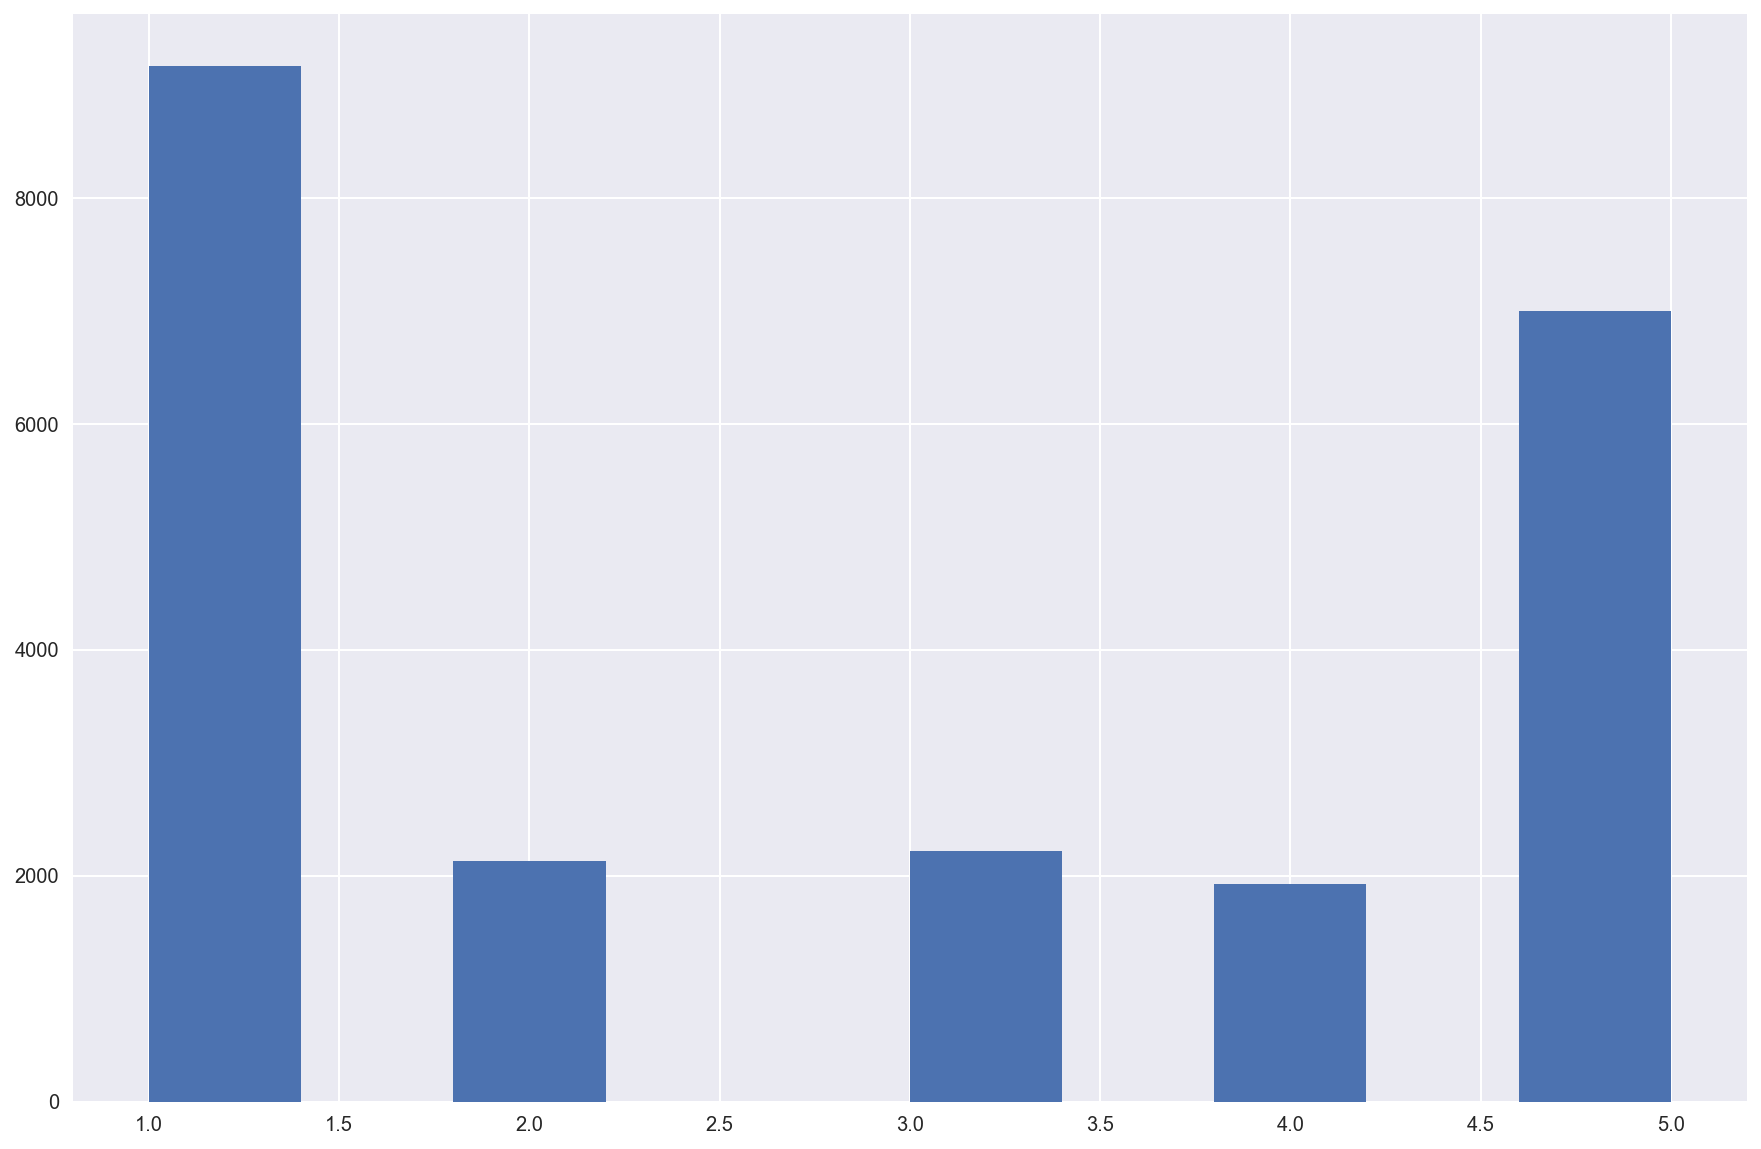

In [18]:
plt.hist(df_nhsrev['score'])
plt.show()

In [20]:
#DATA PREPROCESSING
# Lower casing

# Change the reviews type to string
df_nhsrev['content'] = df_nhsrev['content'].astype(str)# Before lowercasing
# Before lowercasing
print(df_nhsrev['content'][22442])

Where can I get a code? The instructions is not clear


In [21]:
#Lowercase all reviews to see the difference
df_nhsrev['content']= df_nhsrev['content'].apply(lambda x: x.lower())
print(df_nhsrev['content'][22442]) 

where can i get a code? the instructions is not clear


In [22]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hafidz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
#edited from https://www.tensorscience.com/nlp/sentiment-analysis-tutorial-in-python-classifying-reviews-on-movies-and-products
import string

df_nhsrev['wordCount'] = [len(review.split()) for review in df_nhsrev['content']]

df_nhsrev['uppercaseCharCount'] = [sum(char.isupper() for char in review) \
                              for review in df_nhsrev['content']]                           

df_nhsrev['specialCharCount'] = [sum(char in string.punctuation for char in review) \
                            for review in df_nhsrev['content']]               

In [24]:
df_nhsrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","wordCount","uppercaseCharCount","specialCharCount"]]

,content,score,sentiment_polarity,sentiment_subjective,wordCount,uppercaseCharCount,specialCharCount
0,"pointless... absolutely pointless is what this app has unfortunately become. it doesn't trace people you're physically near to anymore or anything of the sort, so you'd be none the wiser if you we...",1,-0.060000,0.680000,59,0,12
1,easy to use once set up,5,0.433333,0.833333,6,0,0
2,from health care and covid-19,5,0.000000,0.000000,5,0,1
3,had half a notification this morning then it disappeared spent all day trying to find it. no idea what i'm supposed to do now apart from worrying,1,-0.133333,0.133333,27,0,2
4,easy to use and fast response,5,0.316667,0.716667,6,0,0
...,...,...,...,...,...,...,...
22438,tells me is installed but not on phone. can't get as far as putting the code i have been given in. doesn't inspire confidence. it eventually downloaded and the code works. this needs to be slicker...,3,0.100000,1.000000,55,0,10
22439,"the emails from the nhs could do a better job of highlighting the access codes, since they do waffle on quite a bit and we're all busy. assuming you did read your email carefully and collected the...",4,0.346667,0.591667,51,0,7
22440,seems to work really well. super simple setup. people stop giving it 1* because you don't have a signup code. that is not what the rating system is for.,5,0.177778,0.407937,29,0,6
22441,"not able to install ,code didn't work",1,-0.250000,0.625000,7,0,2


In [25]:
#Removing stopwords
#Using nltk
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from nltk import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from string import punctuation

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [26]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

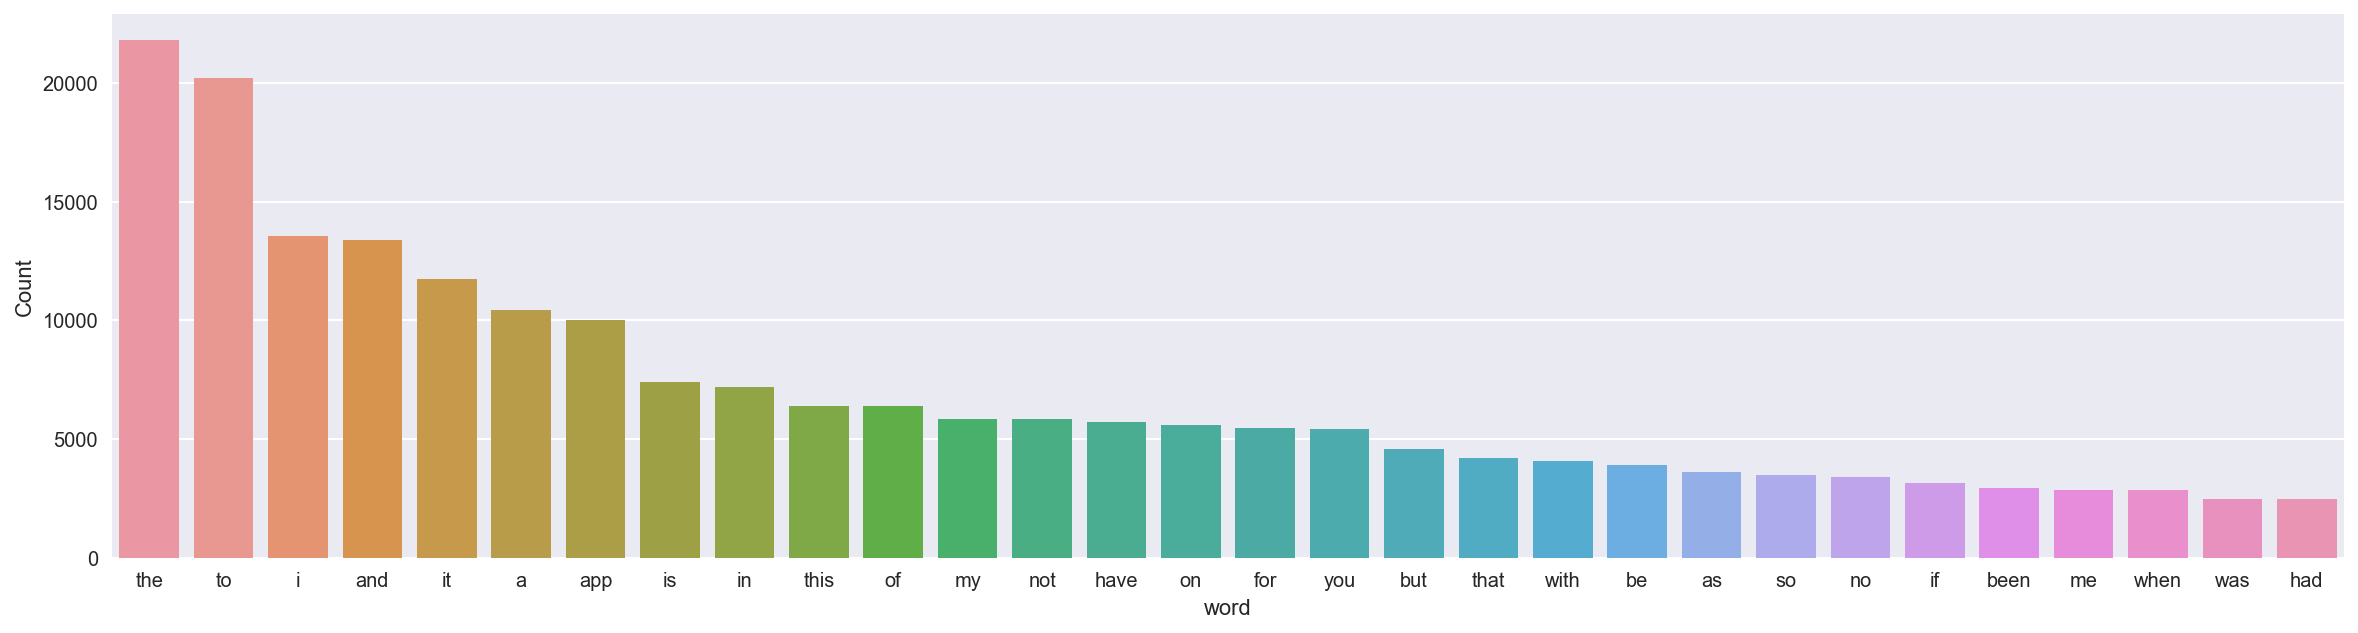

In [27]:
freq_words(df_nhsrev['content'])

In [28]:
#check if there is any special character
alphabet = string.ascii_letters+string.punctuation
print(df_nhsrev.content.str.strip(alphabet).astype(bool).any())

extracted_emojis=[]

def extract_emojis(s):
    expe = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
    return expe.findall(s)
    return expe.sub(r'',s)

for y in df_nhsrev['content']:
    #print(str(extract_emojis(y)))
    extracted_emojis.append(str(extract_emojis(y)))
    
print(extracted_emojis)

True
['[]', '[]', '[]', '[]', '[]', '[]', '[]', "['💪']", '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', "['🙄']", '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', "['👍']", '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', "['🎲']", '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]'

In [29]:
df_nhsrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","wordCount","uppercaseCharCount","specialCharCount"]]

,content,score,sentiment_polarity,sentiment_subjective,wordCount,uppercaseCharCount,specialCharCount
0,"pointless... absolutely pointless is what this app has unfortunately become. it doesn't trace people you're physically near to anymore or anything of the sort, so you'd be none the wiser if you we...",1,-0.060000,0.680000,59,0,12
1,easy to use once set up,5,0.433333,0.833333,6,0,0
2,from health care and covid-19,5,0.000000,0.000000,5,0,1
3,had half a notification this morning then it disappeared spent all day trying to find it. no idea what i'm supposed to do now apart from worrying,1,-0.133333,0.133333,27,0,2
4,easy to use and fast response,5,0.316667,0.716667,6,0,0
...,...,...,...,...,...,...,...
22438,tells me is installed but not on phone. can't get as far as putting the code i have been given in. doesn't inspire confidence. it eventually downloaded and the code works. this needs to be slicker...,3,0.100000,1.000000,55,0,10
22439,"the emails from the nhs could do a better job of highlighting the access codes, since they do waffle on quite a bit and we're all busy. assuming you did read your email carefully and collected the...",4,0.346667,0.591667,51,0,7
22440,seems to work really well. super simple setup. people stop giving it 1* because you don't have a signup code. that is not what the rating system is for.,5,0.177778,0.407937,29,0,6
22441,"not able to install ,code didn't work",1,-0.250000,0.625000,7,0,2


In [30]:
#Add a column name polarity_rating from changing the score of the review into 3 labels: Pos, Negative Neutral
df_nhsrev['sentiment_rating'] = df_nhsrev['score'].apply(lambda x: 'Positive' if x > 3 else('Neutral' if x == 3  else 'Negative'))

In [31]:
df_nhsrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","sentiment_rating"]]

,content,score,sentiment_polarity,sentiment_subjective,sentiment_rating
0,"pointless... absolutely pointless is what this app has unfortunately become. it doesn't trace people you're physically near to anymore or anything of the sort, so you'd be none the wiser if you we...",1,-0.060000,0.680000,Negative
1,easy to use once set up,5,0.433333,0.833333,Positive
2,from health care and covid-19,5,0.000000,0.000000,Positive
3,had half a notification this morning then it disappeared spent all day trying to find it. no idea what i'm supposed to do now apart from worrying,1,-0.133333,0.133333,Negative
4,easy to use and fast response,5,0.316667,0.716667,Positive
...,...,...,...,...,...
22438,tells me is installed but not on phone. can't get as far as putting the code i have been given in. doesn't inspire confidence. it eventually downloaded and the code works. this needs to be slicker...,3,0.100000,1.000000,Neutral
22439,"the emails from the nhs could do a better job of highlighting the access codes, since they do waffle on quite a bit and we're all busy. assuming you did read your email carefully and collected the...",4,0.346667,0.591667,Positive
22440,seems to work really well. super simple setup. people stop giving it 1* because you don't have a signup code. that is not what the rating system is for.,5,0.177778,0.407937,Positive
22441,"not able to install ,code didn't work",1,-0.250000,0.625000,Negative


C:\Users\Hafidz\anaconda3\envs\rstudio\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


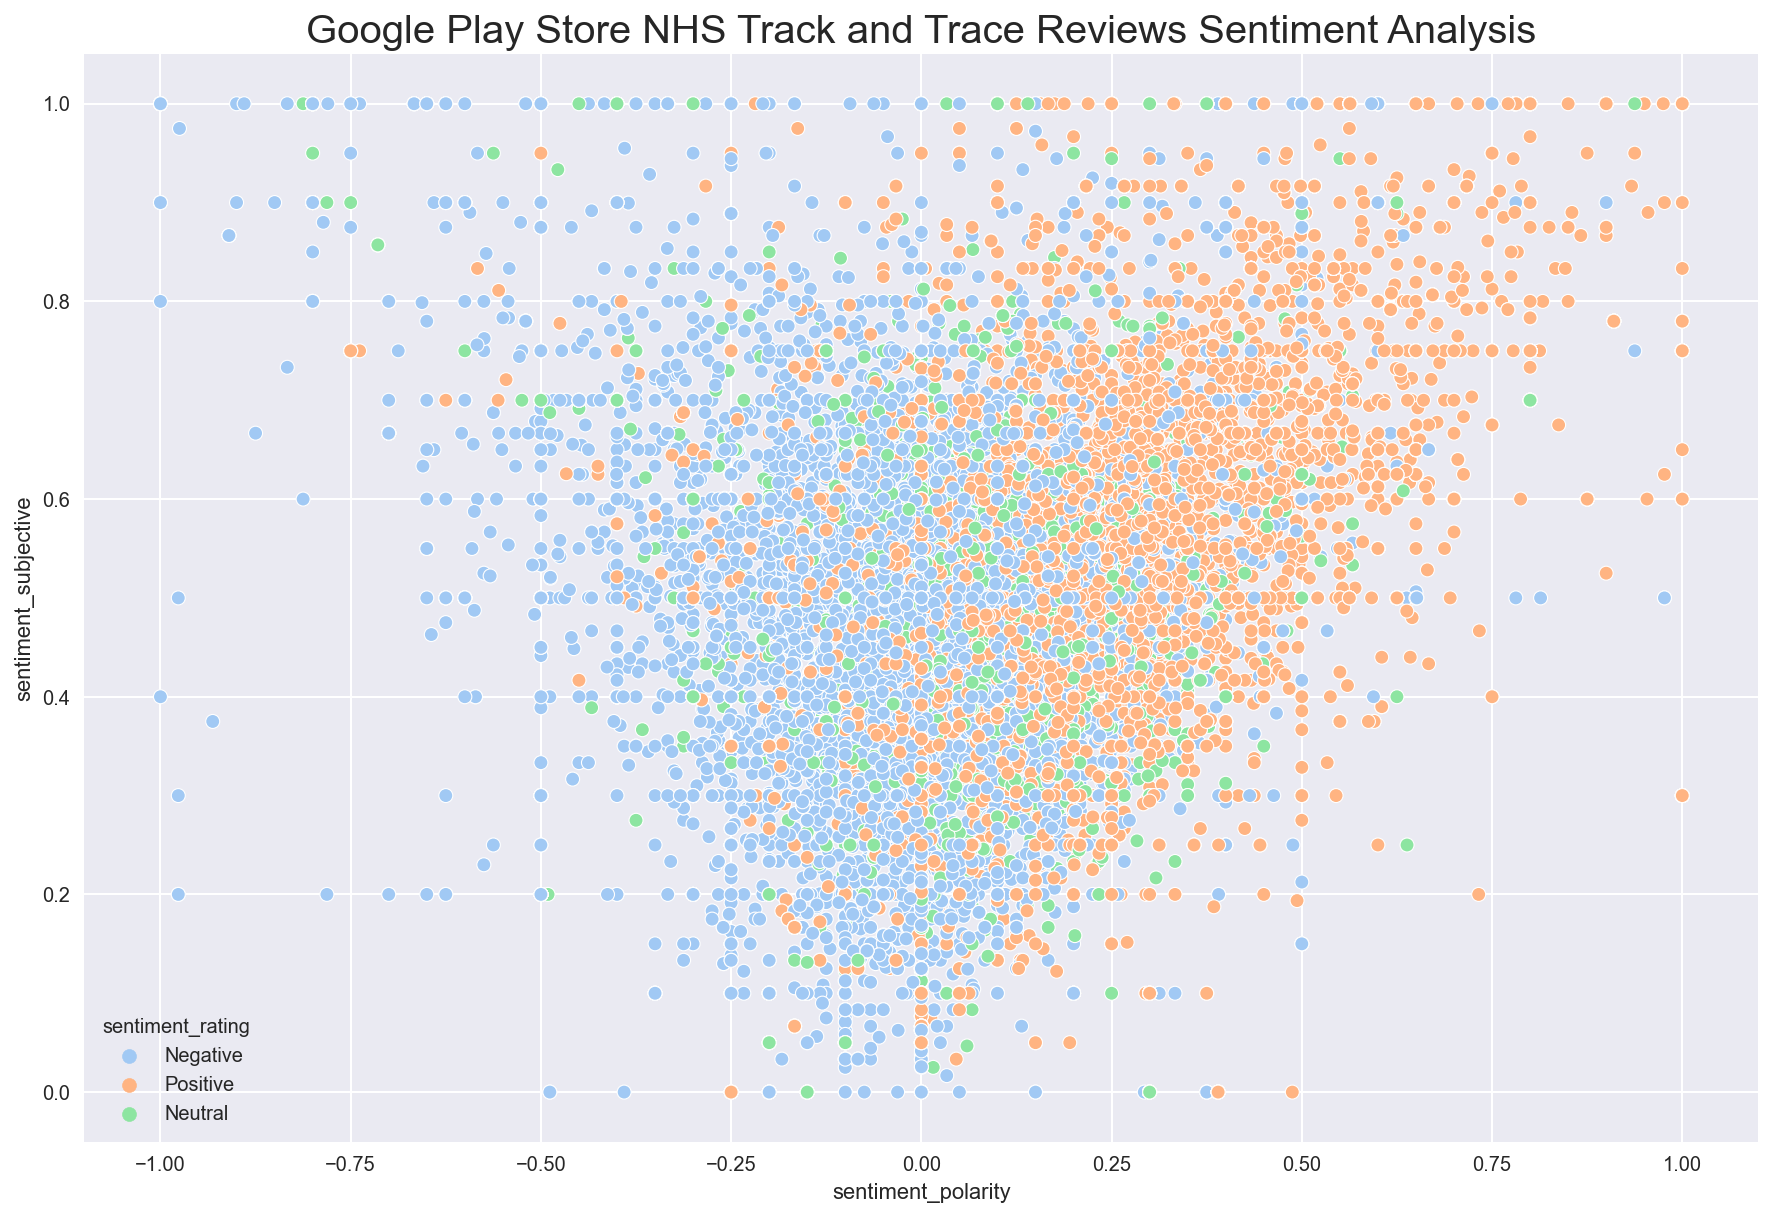

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15, 10))
sns.scatterplot(df_nhsrev['sentiment_polarity'], df_nhsrev['sentiment_subjective'], 
                hue = df_nhsrev['sentiment_rating'], edgecolor='white', palette="pastel")
plt.title("Google Play Store NHS Track and Trace Reviews Sentiment Analysis", fontsize=20)
plt.show()

In [33]:
#Print the extracted emojis review column (content) before stopwords
df_nhsrev.to_csv(r'C:\Users\Hafidz\PhDwork\APPREV\df_nhsrev_before_stopwords_sentiment_rating.csv', index = False)

In [43]:
import nltk
from nltk.corpus import stopwords
stop = stopwords.words('english') + ["someone","still","would","need"]
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [44]:
print(len(stop))

183


In [45]:
df_nhsrev_stopwords = df_nhsrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","sentiment_rating"]]

In [46]:
# Exclude stopwords 
df_nhsrev_stopwords['tweet_without_stopwords'] = df_nhsrev_stopwords['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
print(df_nhsrev_stopwords)

                                                                                                                                                                                                       content  \
0      pointless... absolutely pointless is what this app has unfortunately become. it doesn't trace people you're physically near to anymore or anything of the sort, so you'd be none the wiser if you we...   
1                                                                                                                                                                                      easy to use once set up   
2                                                                                                                                                                                from health care and covid-19   
3                                                            had half a notification this morning then it disappeared spent all day trying to find it. no idea w

In [47]:
pat = r'\b(?:{})\b'.format('|'.join(stop))
df_nhsrev_stopwords['tweet_without_stopwords'] = df_nhsrev_stopwords['content'].str.replace(pat, '')
df_nhsrev_stopwords['tweet_without_stopwords'] = df_nhsrev_stopwords['tweet_without_stopwords'].str.replace(r'\s+', ' ')

C:\Users\Hafidz\anaconda3\envs\rstudio\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
C:\Users\Hafidz\anaconda3\envs\rstudio\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [48]:
#Save into csv after applying stopwords
df_nhsrev_stopwords.to_csv(r'C:\Users\Hafidz\PhDwork\APPREV\df_nhsrev_after_stopwords_sentiment_rating2.csv', index = False)

In [49]:
#Count after stopwords
#edited from https://www.tensorscience.com/nlp/sentiment-analysis-tutorial-in-python-classifying-reviews-on-movies-and-products
import string

df_nhsrev_stopwords['wordCount'] = [len(review.split()) for review in df_nhsrev_stopwords['content']]
df_nhsrev_stopwords['wordCount_after_stopwords'] = [len(review.split()) for review in df_nhsrev_stopwords['tweet_without_stopwords']]


In [60]:
df_nhsrev_stopwords.loc[:,["content","score","sentiment_polarity", "sentiment_rating","wordCount","tweet_without_stopwords", "wordCount_after_stopwords"]]

,content,score,sentiment_polarity,sentiment_rating,wordCount,tweet_without_stopwords,wordCount_after_stopwords
0,"pointless... absolutely pointless is what this app has unfortunately become. it doesn't trace people you're physically near to anymore or anything of the sort, so you'd be none the wiser if you we...",1,-0.060000,Negative,59,"pointless... absolutely pointless app unfortunately become. ' trace people ' physically near anymore anything sort, ' none wiser talking closely covid-positive case 15+ minutes. tells rules place ...",30
1,easy to use once set up,5,0.433333,Positive,6,easy use set,3
2,from health care and covid-19,5,0.000000,Positive,5,health care covid-19,3
3,had half a notification this morning then it disappeared spent all day trying to find it. no idea what i'm supposed to do now apart from worrying,1,-0.133333,Negative,27,half notification morning disappeared spent day trying find . idea ' supposed apart worrying,14
4,easy to use and fast response,5,0.316667,Positive,6,easy use fast response,4
...,...,...,...,...,...,...,...
22438,tells me is installed but not on phone. can't get as far as putting the code i have been given in. doesn't inspire confidence. it eventually downloaded and the code works. this needs to be slicker...,3,0.100000,Neutral,55,tells installed phone. ' get far putting code given . ' inspire confidence. eventually downloaded code works. needs slicker quicker people going use ...people expect get app use immediately.,29
22439,"the emails from the nhs could do a better job of highlighting the access codes, since they do waffle on quite a bit and we're all busy. assuming you did read your email carefully and collected the...",4,0.346667,Positive,51,"emails nhs could better job highlighting access codes, since waffle quite bit ' busy. assuming read email carefully collected one-time code, app seems work nicely. visual design great.",28
22440,seems to work really well. super simple setup. people stop giving it 1* because you don't have a signup code. that is not what the rating system is for.,5,0.177778,Positive,29,seems work really well. super simple setup. people stop giving 1* ' signup code. rating system .,17
22441,"not able to install ,code didn't work",1,-0.250000,Negative,7,"able install ,code ' work",5


In [51]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

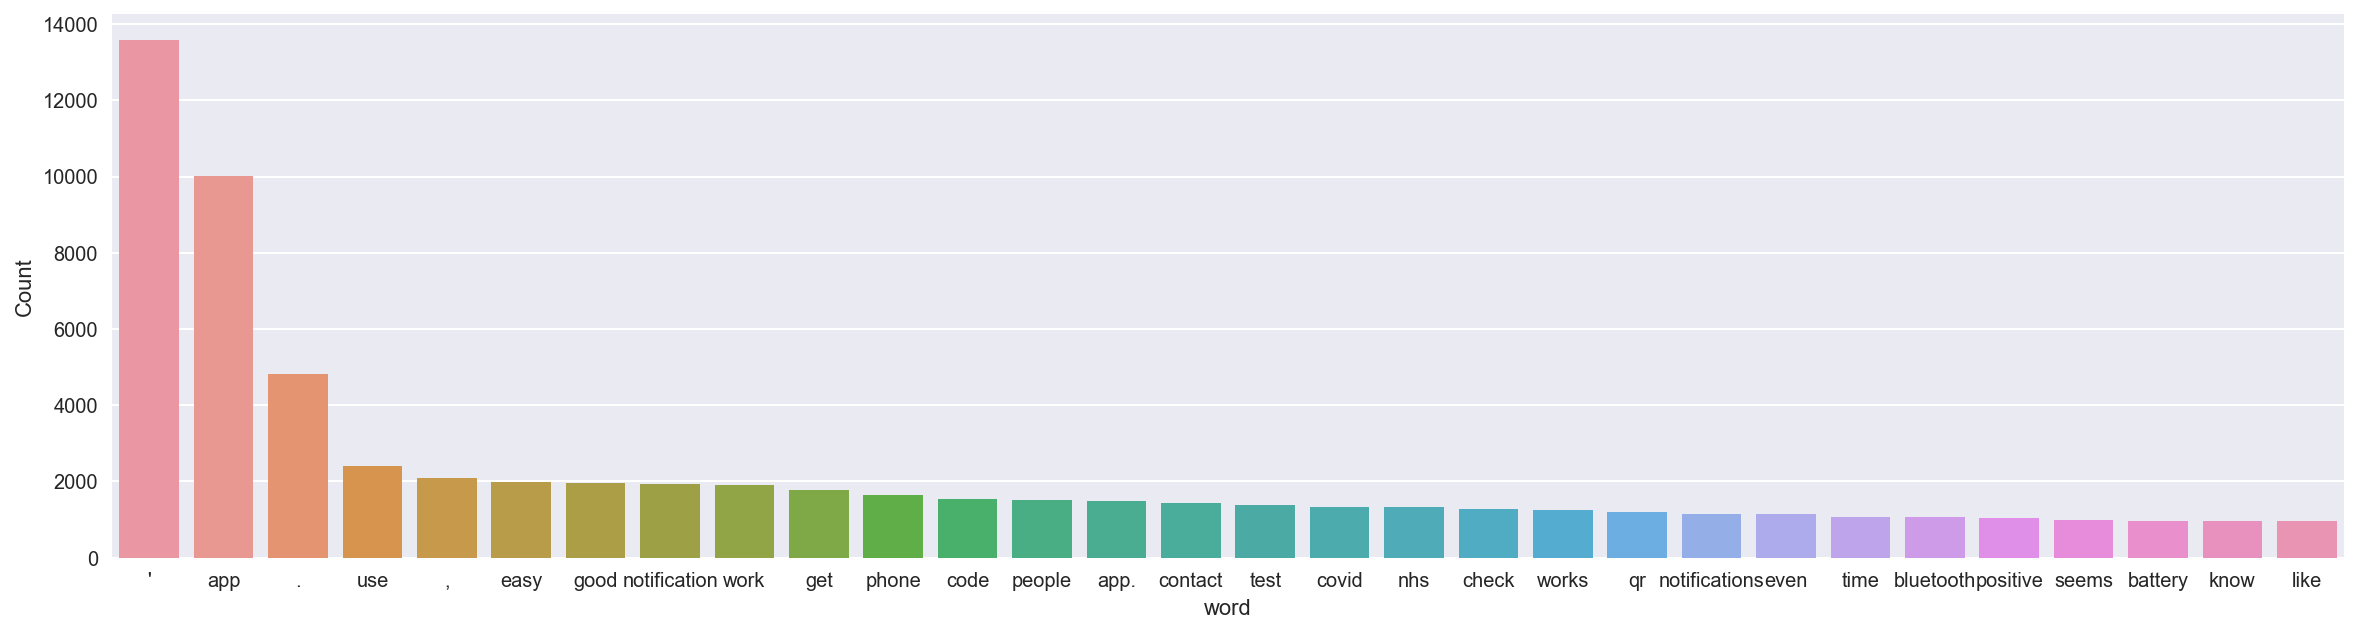

In [52]:
freq_words(df_nhsrev_stopwords['tweet_without_stopwords'])

In [79]:
newStopWords = ["'",".",",", "someone","still","would","need"]

#from nltk.corpus import stopwords
#stoplist = stopwords.words('english') + ['though']

#NOT YET DONE ==== 24 May 2022

In [53]:
#Stemming 

#Stemming function chops off the end of the word 
#and transform the word into its root form. 
#All suffixes like -s, -es, -ed, -ing are removed.

def stemming(x):
    st = PorterStemmer()
    if x is not None:
       for word in x.split():
           st.stem(word)

df_nhsrev_stopwords['tweet_without_stopwords'].apply(lambda x:stemming(x))
print(df_nhsrev_stopwords['tweet_without_stopwords'][22439])

 emails nhs could better job highlighting access codes, since waffle quite bit ' busy. assuming read email carefully collected one-time code, app seems work nicely. visual design great.


In [55]:
#===BIGRAM https://towardsdatascience.com/text-analysis-basics-in-python-443282942ec5 not yet
#Creating bigram/trigram to search 

In [63]:
#DROP NA
df_nhsrev_stopwords.dropna(inplace=True)
df_nhsrev_stopwords.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22443 entries, 0 to 22442
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   content                    22443 non-null  object 
 1   score                      22443 non-null  int64  
 2   sentiment_polarity         22443 non-null  float64
 3   sentiment_subjective       22443 non-null  float64
 4   sentiment_rating           22443 non-null  object 
 5   tweet_without_stopwords    22443 non-null  object 
 6   wordCount                  22443 non-null  int64  
 7   wordCount_after_stopwords  22443 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 1.5+ MB


In [64]:
df_nhsrev_stopwords.loc[:,["content","score","sentiment_rating","wordCount","tweet_without_stopwords", "wordCount_after_stopwords"]]

,content,score,sentiment_rating,wordCount,tweet_without_stopwords,wordCount_after_stopwords
0,"pointless... absolutely pointless is what this app has unfortunately become. it doesn't trace people you're physically near to anymore or anything of the sort, so you'd be none the wiser if you we...",1,Negative,59,"pointless... absolutely pointless app unfortunately become. ' trace people ' physically near anymore anything sort, ' none wiser talking closely covid-positive case 15+ minutes. tells rules place ...",30
1,easy to use once set up,5,Positive,6,easy use set,3
2,from health care and covid-19,5,Positive,5,health care covid-19,3
3,had half a notification this morning then it disappeared spent all day trying to find it. no idea what i'm supposed to do now apart from worrying,1,Negative,27,half notification morning disappeared spent day trying find . idea ' supposed apart worrying,14
4,easy to use and fast response,5,Positive,6,easy use fast response,4
...,...,...,...,...,...,...
22438,tells me is installed but not on phone. can't get as far as putting the code i have been given in. doesn't inspire confidence. it eventually downloaded and the code works. this needs to be slicker...,3,Neutral,55,tells installed phone. ' get far putting code given . ' inspire confidence. eventually downloaded code works. needs slicker quicker people going use ...people expect get app use immediately.,29
22439,"the emails from the nhs could do a better job of highlighting the access codes, since they do waffle on quite a bit and we're all busy. assuming you did read your email carefully and collected the...",4,Positive,51,"emails nhs could better job highlighting access codes, since waffle quite bit ' busy. assuming read email carefully collected one-time code, app seems work nicely. visual design great.",28
22440,seems to work really well. super simple setup. people stop giving it 1* because you don't have a signup code. that is not what the rating system is for.,5,Positive,29,seems work really well. super simple setup. people stop giving 1* ' signup code. rating system .,17
22441,"not able to install ,code didn't work",1,Negative,7,"able install ,code ' work",5


In [ ]:
!